##### Copyright 2021 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Introduction

본 튜토리얼에서는 OpenAI Gym 의 CartPole 환경에서 DQN (Deep Q Learning) 에이전트를 학습하는 방법을 보여드립니다. 

![Cartpole environment](https://www.tensorflow.org/agents/tutorials/images/cartpole.png?hl=ko)*이탤릭체 텍스트*


## 설정

필요한 라이브러리를 설치합니다.

In [2]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [770 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Pack

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## 하이퍼파라미터

In [4]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 200 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

## 환경

RL의 환경은 우리가 해결하려는 작업이나 문제를 나타냅니다. 표준 환경을 사용하여 에이젠트를 생성할 수 있습니다. 

OpenAI Gym 라이브러리에서 CartPole 환경을 로드해 보겠습니다.

In [5]:
env = suite_gym.load(env_name)

CartPole 환경을 렌더링한 화면은 아래와 같습니다. 자유롭게 흔들리는 기둥이 카트에 부착되어 있습니다. 목표는 막대가 넘어지지 않도록 카트를 오른쪽이나 왼쪽으로 움직이는 것입니다.

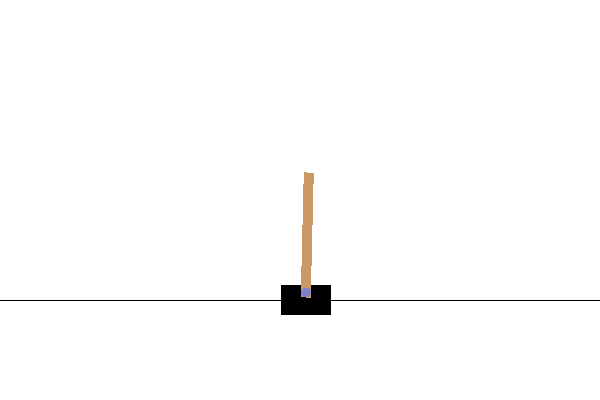

In [6]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

`time_step = environment.step(action)`은 필요한 'action' 환경에 대한 관찰과 보상을 리턴합니다. 아래의 Observation Spec은 수레의 위치와 속도, 기둥의 각 위치와 속도를 확인할 수 있고 Action Spec은 수레를 움직일지 아닐지에 대한 변수를 가지고 있습니다.

In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.04200335, -0.01040119,  0.04093799, -0.03721555], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.04179533,  0.18411052,  0.04019368, -0.31670624], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


일반적으로 교육용 환경과 평가 환경의 두 가지 환경을 만듭니다. 대부분의 환경은 순수한 파이썬으로 작성되어 있지만, 쉽게 TensorFlow로 변환 할 수 있습니다. 원래 환경의 API는 NumPy와 배열을 사용하는데, TFPyEnvironment가 간편하게 Tensors 및 TensorFlow 환경으로 변환 가능합니다.

In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## 에이전트

강화학습 에이전트를 생성하기 위해서는 'Actor Network'가 필요합니다. 'Actor Network는 주어진 환경을 관찰하고 그에 따른 행동을 하는 네트워크 입니다.

In [21]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

네트워크를 학습하기 위해서 'optimizer'를 선언합니다. 

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## 정책

주어진 time_step의 동작이나 행동을 보면서 정책을 만듭니다.

에이전트에는 평가/배포에 사용되는 기본 정책(agent.policy)과 데이터 수집에 사용되는 또 다른 정책(agent.collect_policy)의 두 가지 정책이 있습니다.

In [12]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## 측정항목 및 평가

정책을 평가하는 데 사용되는 가장 일반적인 지표는 평균 수익률입니다. 수익은 에피소드에 대한 환경에서 정책을 실행하는 동안 얻은 보상의 합계이며 일반적으로 몇 에피소드에 걸쳐 이를 평균화합니다. 평균 수익 측정항목은 다음과 같이 계산할 수 있습니다.


In [13]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.

## Replay Buffer
환경에서 수집된 데이터를 효과적으로 추적하기 위해서 [Reverb](https://deepmind.com/research/open-source/Reverb)를 사용했습니다. 

Replay Buffer는 에이전트로부터 얻어 질 수 있는 데이터를 저장합니다.

In [14]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      tf_agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    table_name=table_name,
    sequence_length=None,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

## 데이터 수집

강화학습은 전체 에피소드에서 학습하므로 주어진 데이터 수집 정책을 사용하여 에피소드를 수집하고 데이터(관찰, 액션, 보상 등)를 Replay Buffer에 저장하는 함수를 정의합니다.

In [15]:
#@test {"skip": true}

def collect_episode(environment, policy, num_episodes):

  driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(
      policy, use_tf_function=True),
    [rb_observer],
    max_episodes=num_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)

## 에이전트 학습

훈련 루프에는 환경에서 데이터를 수집하고 에이전트의 네트워크를 최적화하는 작업이 모두 포함됩니다. 그 과정에서 때때로 에이전트의 정책을 평가하여 우리가 어떻게 하고 있는지 확인할 것입니다.

다음은 실행하는 데 ~3분 정도 걸립니다.

In [16]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)  

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.39 µs
step = 25: loss = 0.8832499980926514
step = 50: loss = 1.280195713043213
step = 50: Average Return = 44.29999923706055
step = 75: loss = 1.1142802238464355
step = 100: loss = 1.0358829498291016
step = 100: Average Return = 48.20000076293945
step = 125: loss = 1.4463634490966797
step = 150: loss = 0.3548130989074707
step = 150: Average Return = 200.0
step = 175: loss = 1.0183138847351074
step = 200: loss = 1.4889183044433594
step = 200: Average Return = 199.1999969482422
step = 225: loss = -3.428696632385254
step = 250: loss = 2.2500534057617188
step = 250: Average Return = 200.0


## 시각화


### 그래프

에이전트의 성능을 보기 위해 그래프입니다. 가로축은 학습 Step이고 세로축은 Cartpole이 넘어지지 않는 시간입니다. 단계의 최대 수가 200이기 때문에, 세로축은 200 입니다.

(2.0749999999999993, 250.0)

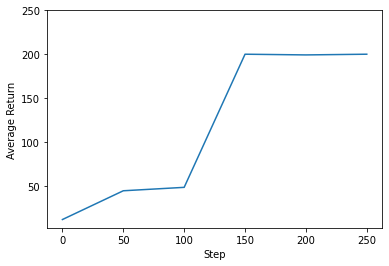

In [22]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

### 비디오


각 단계에서 환경을 렌더링하여 시각화합니다.


In [23]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [24]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)